<a href="https://colab.research.google.com/github/Sbarbagnem/AdvancedProject/blob/master/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module

In [0]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.21.3
!apt-get install swig
!pip install smac
!pip install smac[all]
!pip install smt

In [0]:
import cv2
import os
import numpy as np
import pandas as pd
from math import ceil
import xml.etree.ElementTree as ET
from google.colab import drive
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, ResNet50, MobileNet
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from keras.applications.mobilenet import preprocess_input as preprocess_input_mobilenet
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from keras import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, SGD
import tensorflow as tf


from smac.configspace import ConfigurationSpace 
from smac.configspace import UniformFloatHyperparameter, UniformIntegerHyperparameter, CategoricalHyperparameter, InCondition
from smac.configspace import Configuration # serve per costruire le configurazioni iniziali da passare alla funzione di minimizzazione
from smac.scenario.scenario import Scenario
from smac.facade.smac_bo_facade import SMAC4BO # bayesian optimization with GaussianProcess
from smac.facade.smac_hpo_facade import SMAC4HPO # bayesian optimization with RandomForest
from smac.optimizer.acquisition import EI, LCB, PI
from smac.runhistory.runhistory import RunHistory # util class to collect all data of optimization
from smac.initial_design.latin_hypercube_design import LHDesign
from smac.stats.stats import Stats # util class to save history on directory
from smac.utils.io.traj_logging import TrajLogger
#from smac.optimizer.objective import average_cost

from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, KFold

import warnings
warnings.filterwarnings("ignore")

# Costant

In [0]:
drive.mount('/content/drive')

PATH_ANNOTATIONS = '/content/drive/My Drive/Laurea Magistrale/Adavanched Machine Learning/Progetto/Dataset/Train/Annotations/'
PATH_MAIN = '/content/drive/My Drive/Laurea Magistrale/Adavanched Machine Learning/Progetto/Dataset/Train/Main/'
PATH_IMAGES = '/content/drive/My Drive/Laurea Magistrale/Adavanched Machine Learning/Progetto/Dataset/Train/Images/'
PATH_IMAGES_CROPPED_TRAIN = '/content/drive/My Drive/Laurea Magistrale/Adavanched Machine Learning/Progetto/Dataset/Train/Cropped_train/'
PATH_IMAGES_CROPPED_VAL_TEST = '/content/drive/My Drive/Laurea Magistrale/Adavanched Machine Learning/Progetto/Dataset/Train/Cropped_val_test/'
PATH_OPTIMIZATION = '/content/drive/My Drive/Laurea Magistrale/Adavanched Machine Learning/Progetto/Ottimizzazione/'

BATCH_SIZE = 64
IM_SIZE = (128, 128)

LABELS = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 
          'car', 'cat', 'chair', 'cow', 'diningtable',
          'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
          'train', 'tvmonitor']

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Directory for cropped images

In [0]:
# creo 20 directory, una per ogni classe, per fare classificazione (flow_from_datframe) sulle immagini croppate
def create_directories(path, labels):
  for label in labels:
    os.mkdir(os.path.join(path, label))

create_folder_classes = False

if create_folder_classes == True:
  create_directories(PATH_IMAGES_CROPPED_TRAIN, LABELS)
  create_directories(PATH_IMAGES_CROPPED_VAL_TEST, LABELS)

# Util function for mapping from label to #class

In [0]:
def create_dict_mapping(labels):
  mapping = {}
  for label,i in zip(labels, range(len(labels))):
    mapping[label] = i
  return mapping

def from_label_to_number(mapping, label):
  return mapping[label]

def from_number_to_label(mapping, number):
  for key, val in mapping.items(): 
    if val == number: 
      return key 
  return "key doesn't exist"

def from_onehot_to_label(mapping, one_hot):
  return from_number_to_label(mapping,np.where(one_hot == 1)[0][0])

In [0]:
mapping = create_dict_mapping(LABELS)
print(mapping)

{'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}


# Crop and save image for class

In [0]:
def crop_image(img, x_min, y_min, x_max, y_max):
  crop_img = img[y_min:y_max, x_min:x_max]
  return crop_img

In [0]:
def list_images(path_images, path_txt, file_txt):
  '''
  creo liste immagini presenti in file_txt
  '''
  temp = []
  f = open(os.path.join(path_txt, file_txt), "r")
  for line in f.readlines():
    temp.append(line.split('\n')[0] + '.jpg')
  list_images = [os.path.join(path_images, name) for name in temp]
  print('Ho trovato ', len(list_images), 'per il file ', file_txt)
  return list_images

# creo liste immagini da train.txt e val.txt
list_images_train = list_images(PATH_IMAGES, PATH_MAIN, 'train.txt')
list_images_val = list_images(PATH_IMAGES, PATH_MAIN, 'val.txt')

In [0]:
def read_and_crop(list_images, annotation_dir, path_to_save):
  '''
  leggo annotations dei file presenti nelle due liste di immagini 
  '''
  for path in list_images:
    image_name = path.split('/')[-1].split('.')[0] 
    print(image_name)
    with open(os.path.join(annotation_dir, image_name + '.xml')) as f:
      read_xml(f.read(), path, path_to_save)
  return

def read_xml(file_xml, path_image, path_to_save):
  '''
  leggo xml e per ogni box che trovo croppo e salvo
  '''
  img = cv2.imread(path_image)  
  root = ET.XML(file_xml)
  for _, child in enumerate(root):
    if child.tag == 'object':
      x_min = None
      y_min = None
      x_max = None
      y_max = None
      for subchild in child:
        if subchild.tag == 'name':
          name_object = subchild.text
          #print(name_object)
        if subchild.tag == 'bndbox':
          for bndbox in subchild:
            if bndbox.tag == 'xmin':
              x_min = int(bndbox.text)
              #print('x_min ', x_min)
            if bndbox.tag == 'ymin':
              y_min = int(bndbox.text)
              #print('y_min ', y_min)
            if bndbox.tag == 'xmax':
              x_max = int(bndbox.text)
              #print('x_max ', x_max)
            if bndbox.tag == 'ymax':
              y_max = int(bndbox.text)
              #print('y_max ', y_max)
        if(x_min!=None and y_min!=None and x_max!=None and y_max!=None):
          image_cropped = crop_image(img, x_min, y_min, x_max, y_max)
          x_min = None
          y_min = None
          x_max = None
          y_max = None
          #cv2_imshow(image_cropped)
          save_image_cropped(name_object, image_cropped, path_to_save)
  return 

def save_image_cropped(obj, img, path_to_save):
  '''
  salvo immagine croppata con numero progressivo in base 
  all'ultima presente nella cartella
  '''
  list_dir_classes = os.listdir(path_to_save)
  for dir_class in list_dir_classes:
    if dir_class == obj:
      dir_temp = os.path.join(path_to_save,dir_class)
      list_temp = os.listdir(dir_temp)
      if list_temp == []:
        cv2.imwrite(os.path.join(dir_temp, obj + '_1.jpg'), img)
      else:
        number_file = int(list_temp[-1].split('.')[0].split('_')[1]) + 1
        cv2.imwrite(os.path.join(dir_temp, obj + '_' + str(number_file) + '.jpg'), img)
  return

read_and_crop(list_images=list_images_val, annotation_dir=PATH_ANNOTATIONS, path_to_save=PATH_IMAGES_CROPPED_VAL_TEST)

# Util function to create generator

In [0]:
def create_generator( batch_size, im_size, base_net, train_directory, val_directory, labels,
                      validation_split, aug, augment_params):
  
  if base_net == 'vgg16':
    preprocess_function = preprocess_input_vgg16
  elif base_net == 'mobilenet':
    preprocess_function = preprocess_input_mobilenet
  elif base_net == 'resnet':
    preprocess_function = preprocess_input_resnet50

  if not(aug):
    img_gen_train = ImageDataGenerator(preprocessing_function=preprocess_function)
  elif aug:
    img_gen_train = ImageDataGenerator( preprocessing_function=preprocess_function,
                                        **augment_params)  


  img_gen_val = ImageDataGenerator( preprocessing_function=preprocess_function,
                                    validation_split = validation_split
                                  )
    
  train_gen = img_gen_train.flow_from_directory(
      directory = train_directory,
      shuffle=True,
      class_mode='categorical',
      target_size=im_size,
      batch_size=batch_size,
      classes=labels,
      seed=42
  )

  val_gen = img_gen_val.flow_from_directory(
      directory = val_directory,
      shuffle=False,
      class_mode='categorical',
      target_size=im_size,
      batch_size=batch_size,
      subset='training',
      classes=labels,
      seed=42
  )

  test_gen = img_gen_val.flow_from_directory(
      directory = val_directory,
      shuffle=False,
      class_mode='categorical',
      target_size=im_size,
      batch_size=batch_size,
      subset='validation',
      classes=labels,
      seed=42
  )

  return train_gen, val_gen, test_gen

# Util function for frequency classes

In [0]:
def get_frequency_from_generator(generator):
  mapping = generator.class_indices
  classes, count = np.unique(generator.labels, return_counts=True)
  labels = [from_number_to_label(mapping, label) for label in classes]
  freq = count
  return labels, freq

def normalize_frequency(freq):
  min_freq = np.min(freq)
  weigh = [min_freq/x for x in freq]
  return weigh * freq, weigh

def plot_label_frequency(labels, freq):
  freq = freq / np.sum(freq)
  l = list(range(1, len(labels)+1))
  plt.barh(l, width=freq, height=0.5)
  plt.yticks(l, labels, rotation='horizontal')
  plt.show()

def plot_stacked_bar_freq(labels, freq, freq_normalize):
  N = len(labels)
  ind = np.arange(N)    # the x locations for the groups
  width = 0.35       # the width of the bars: can also be len(x) sequence

  p1 = plt.bar(ind, freq, width)
  p2 = plt.bar(ind, freq_normalize, width)

  plt.ylabel('Frequency')
  plt.legend((p1[0], p2[0]), ('Freq', 'Freq_normalize'))

  plt.show() 

# Util function to create model

In [0]:
def create_model(base_net, freeze_all, freeze_to, dense, dropout, drop_out, im_size):
  if base_net == 'vgg16':
    base_model = VGG16(weights = 'imagenet', input_shape=im_size + (3,), include_top = False)
  elif base_net == 'resnet':
    base_model = ResNet50(weights = 'imagenet', input_shape=im_size + (3,), include_top = False)
  elif base_net == 'mobilenet':
    base_model = MobileNet(weights = 'imagenet', input_shape=im_size + (3,), include_top = False)

  #x = base_model.output
  x = base_model.layers[-1].output
  #x = Flatten()(x)
  x = GlobalAveragePooling2D()(x)
  for layer in dense:
    x = Dense(layer, activation='relu')(x)
    if drop_out:
      x = Dropout(dropout)(x)
  predictions = Dense(20, activation = 'softmax')(x)
  model = Model(input = base_model.input, output = predictions)

  if freeze_all == True:
    for layer in base_model.layers:
      layer.trainable=False
  else:
    for layer in base_model.layers[:freeze_to]:
      layer.trainable=False
    for layer in model.layers[freeze_to:]:
      layer.trainable = True
      
  return model

# Util function to plot performance epoch

In [0]:
def plot_performance(history):
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

# Experiments

## Set up generator and model

In [0]:
base_net = 'mobilenet'

augment_params = dict(  rotation_range=30,
                        #width_shift_range=0.2,
                        #height_shift_range=0.2,
                        horizontal_flip=True,
                        #brightness_range=[0.4,1.0],
                        zoom_range=0.1
                      )

train_gen, val_gen, test_gen = create_generator(batch_size=BATCH_SIZE, 
                                                im_size=IM_SIZE, 
                                                base_net=base_net, 
                                                train_directory=PATH_IMAGES_CROPPED_TRAIN, 
                                                val_directory=PATH_IMAGES_CROPPED_VAL_TEST, 
                                                labels=LABELS,
                                                validation_split=0.7,
                                                aug=True,
                                                augment_params=augment_params
                                                )

In [0]:
x,y = train_gen.next()
for i in range(0,63):
    image = x[i]
    plt.figure()
    plt.imshow(image)
    plt.title(from_onehot_to_label(mapping, y[i]))
    plt.show

train_gen.reset()

## Analyze frequency label in generator

In [0]:
labels, freq = get_frequency_from_generator(train_gen)
plot_label_frequency(labels, freq)
freq_normalize, weigh = normalize_frequency(freq)
#plot_label_frequency(labels, freq_normalize)
plot_stacked_bar_freq(labels, freq, freq_normalize)

# dict for weigh model
weigh_class = {}
for label,i in zip(labels, weigh):
  weigh_class[from_label_to_number(mapping, label)] = i

weigh_class_sklearn = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_gen.classes),
                                                 train_gen.classes)

pesi = dict()

for label,peso in zip(range(len(LABELS)), weigh_class_sklearn):
  pesi[label] = peso
plot_stacked_bar_freq(labels, freq, freq*weigh_class_sklearn)

## Focal loss

In [0]:
def focal_loss(gamma=2., alpha=0.25):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

## Set up iper-parameter for fit

In [0]:
loss = 'binary_crossentropy'
optimizer = 'adam'
reduce_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, 
                                      verbose=1, mode='auto', min_delta=0.0001, 
                                      cooldown=0, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3, 
                           verbose=1
                           )
metrics = ['categorical_accuracy']
epochs = 30
steps_per_epoch = ceil(train_gen.n / train_gen.batch_size)
validation_steps = ceil(val_gen.n / val_gen.batch_size)
class_weights = pesi
dense = [128, 128]

In [0]:
model = create_model( base_net='mobilenet', 
                      freeze_all=False, 
                      freeze_to=74, 
                      dense=dense,
                      dropout=0.2,
                      drop_out=True,
                      im_size=IM_SIZE
                     )

#model.summary()

#for i,layer in zip(range(len(model.layers)), model.layers):
#  print(i, ' ', layer, layer.trainable)

model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=metrics
              )

net_history = model.fit_generator(train_gen, epochs=epochs, verbose=1,
                                  validation_data = val_gen,
                                  steps_per_epoch = steps_per_epoch,
                                  validation_steps = validation_steps,
                                  callbacks = [early_stop, reduce_on_plateau],
                                  workers = 4,
                                  use_multiprocessing=True,
                                  #class_weight = class_weights
                                  )

train_gen.reset()
val_gen.reset()

17227776/17225924 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


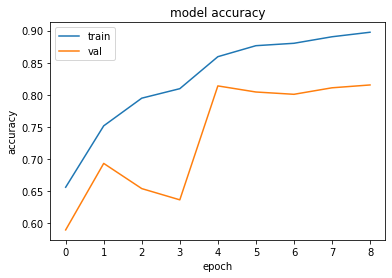

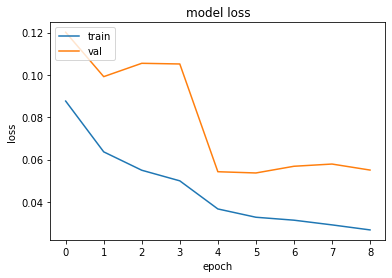

In [0]:
plot_performance(net_history)

# Ottimizzazione

## CNN_for_optimization

In [0]:
def dataframe_path_class(path_images):
  df = pd.DataFrame(columns=['absolute_path', 'class'])
  list_dir = os.listdir(path_images)
  for sub_dir in list_dir:
    list_images = os.listdir(os.path.join(path_images, sub_dir))  
    for image in list_images:
      df = df.append({'absolute_path': os.path.join(path_images, sub_dir, image),
                      'class' : str(sub_dir)} , 
                     ignore_index=True)
  return df

#pd.set_option('max_colwidth', -1)
df_train = dataframe_path_class(PATH_IMAGES_CROPPED_TRAIN)
df_val_test = dataframe_path_class(PATH_IMAGES_CROPPED_VAL_TEST)

# creo df_test che uso solo dopo ottimizzazione iperparametri
df_test, df_val = train_test_split(df_val_test, test_size=0.5)

# unisco df_val a df_train per avere un train generale su cui eseguire k-cross-fold validation
df_train = df_train.append(df_val, ignore_index=True)

# salvo i due dataframe
df_train.to_csv(PATH_OPTIMIZATION + 'train.csv')
df_test.to_csv(PATH_OPTIMIZATION + 'test.csv')

# da df_train tiro fuori degli esempi che userò come test nell k-cross-fold-validation
#df_train, df_test = train_test_split(df_train, test_size=0.2)

#df_train.to_csv(PATH_OPTIMIZATION + 'train_for_k_cross.csv')
#df_test.tocsv(PATH_OPTIMIZATION + 'test_for_k_cross.csv')

df_train = pd.read_csv(PATH_OPTIMIZATION + 'train.csv')
df_test = pd.read_csv(PATH_OPTIMIZATION + 'test.csv')

In [0]:
'''
def k_cross_fold_validation(model, 
                        df_train,
                        early_stop,
                        reduce_on_plateau):
'''

## Training with K-fold cross validation
kf = KFold(n_splits=3, random_state=None, shuffle=True)

accuracy_on_fold = []

trainGenerator = ImageDataGenerator(preprocessing_function=preprocess_input_mobilenet,
                                  rotation_range=0.2,
                                  horizontal_flip=True,
                                  zoom_range=0.1)
valGenerator = ImageDataGenerator(preprocessing_function=preprocess_input_mobilenet)

i = 1
for train_index, val_index in kf.split(df_train):
  trainData = df_train.iloc[train_index,:]

  # divido ulteriormente il train per avere un validation con cui poter usare 
  # early stopping e reduce_learning_rate_on_plateau durante fit
  trainData, valData = train_test_split(trainData, test_size=0.2)

  testData = df_train.iloc[val_index,:]

  print("=========================================")
  print("====== K Fold Validation step => %d =======" % (i))
  print("=========================================")

  print("Flow from train dataframe")
  train_gen = trainGenerator.flow_from_dataframe(
    dataframe = trainData,
    x_col='absolute_path',
    y_col='class',
    shuffle=True,
    class_mode='categorical',
    target_size=IM_SIZE,
    batch_size=BATCH_SIZE,
    classes=LABELS,
    #seed=42
  )

  print("Flow from val dataframe")
  val_gen = valGenerator.flow_from_dataframe(
    dataframe = valData,
    x_col='absolute_path',
    y_col='class',
    shuffle=False,
    class_mode='categorical',
    target_size=IM_SIZE,
    batch_size=BATCH_SIZE,
    classes=LABELS,
    #seed=42
  )

  print("Flow from test dataframe")
  test_gen = valGenerator.flow_from_dataframe(
    dataframe = testData,
    x_col='absolute_path',
    y_col='class',
    shuffle=False,
    class_mode='categorical',
    target_size=IM_SIZE,
    batch_size=BATCH_SIZE,
    classes=LABELS,
    #seed=42
  ) 

  step_train = ceil(train_gen.n/train_gen.batch_size)
  step_val = ceil(val_gen.n/val_gen.batch_size)
  step_test = ceil(test_gen.n/test_gen.batch_size)

  model.compile(loss='binary_crossentropy', 
            optimizer='adam', 
            metrics=['categorical_accuracy']
            )

  print("Inizio fit")
  model.fit_generator(train_gen, 
                      epochs=40, 
                      verbose=1,
                      validation_data = val_gen,
                      steps_per_epoch = step_train,
                      validation_steps = step_val,
                      callbacks = [early_stop, reduce_on_plateau],
                      #workers = 4,
                      #use_multiprocessing=True
                  )

  # test on testData
  print("Predict on test")
  predictions = model.predict_generator(test_gen, 
                                        steps=step_test,
                                        #workers=4, 
                                        #use_multiprocessing=True
                                        )

  model.reset_states()

  predict_classes = np.argmax(predictions, axis=1)

  accuracy_on_fold.append(accuracy_score(y_true=test_gen.classes, 
                                         y_pred=predict_classes))

  i+=1

In [0]:
temp_accuracy = accuracy_on_fold

print(np.mean(temp_accuracy))

In [0]:
def cnn_for_optimization(cfg):

  # creo modello sulla base delle configurazioni in cfg
  if cfg['number_layer'] == 2:
    dense = [cfg['number_first_layer'], cfg['number_second_layer']]
  elif cfg['number_layer'] == 1:
    dense = [cfg['number_first_layer']]

  model = create_model( base_net='mobilenet', 
                        freeze_all=False, 
                        freeze_to=74, 
                        dense=dense,
                        dropout=cfg['dropout'],
                        drop_out=True,
                        im_size=IM_SIZE
                      )
  
  # compilo
  if cfg['optimizer'] == 'SGD':
    optimizer = SGD(lr=cgf['learning_rate'], momentum=cfg['momentum'])
    if cfg['nestorov'] == True:
      optimizer.nestorov = True
  elif cfg['optimizer'] == 'adam':
    optimizer = Adam(lr=cfg['learning_rate'])

  model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['categorical_accuracy']
              )
  
  # fitto su generator (posso passarlo come parametro o globale??)
  reduce_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, 
                                        verbose=1, mode='auto', min_delta=0.0001, 
                                        cooldown=0, min_lr=0.00001)
  early_stop = EarlyStopping(monitor='val_loss', 
                            patience=3, 
                            verbose=1
                            )
  net_history = model.fit_generator(train_gen, epochs=50, verbose=0,
                                  steps_per_epoch = steps_per_epoch,
                                  callbacks = [early_stop, reduce_on_plateau],
                                  workers = 4,
                                  use_multiprocessing=True
                                  )
  
  # calcolo accuratezza su validation 
  # return 1 - accuratezza

## Configuration space

In [0]:
cs = ConfigurationSpace()

# iper-parametri da ottimizzare
'''
  Optimizier: categorical ('adam', 'SGD')
  Learning_rate: uniform_float [0.01, 0.00001]
  Momentum: categorical and condition (True,False) if 'SGD'
  Nestorov: uniform_float and condition [0.9, 0.8] if 'SGD'
  Dropout: uniform_float [0.2,0.4]
  Number_fully_connected: categorical (1,2)
  Number_neurons_first_layer: uniform_integer [256, 1024]
  Numebr_neurons_second_layer: uniform_integer and condition [256,1024] if number_fully_connected==2
'''
optimizier_param = CategoricalHyperparameter(name='optimizier',
                                             choices=['adam', 'SGD'],
                                             default_value='SGD')

lr_param = UniformFloatHyperparameter(name="learning_rate", 
                                      lower=0.00001, 
                                      upper=0.01, 
                                      default_value=0.001)

momentum_param = UniformFloatHyperparameter(name='momentum',
                                            lower=0.1,
                                            upper=0.9,
                                            default_value=0.5
                                            )
cond_momentum = InCondition(child=momentum_param, 
                            parent=optimizier_param, 
                            values=['SGD'])

nestorov_param = CategoricalHyperparameter(name="nestorov", 
                                           choices=[True, False], 
                                           default_value=False)
cond_nestorov = InCondition(child=nestorov_param, 
                            parent=optimizier_param, 
                            values=['SGD'])

dropout_param = UniformFloatHyperparameter(name='dropout',
                                           lower=0.2,
                                           upper=0.4,
                                           default_value=0.3)

number_layer_param = CategoricalHyperparameter(name='number_layer',
                                         choices=[1,2],
                                         default_value=2)

neurons_first_layer_param = UniformIntegerHyperparameter(name='number_first_layer',
                                                   lower=256,
                                                   upper=1024,
                                                   default_value=512)

neurons_second_layer_param = UniformIntegerHyperparameter(name='number_second_layer',
                                                   lower=256,
                                                   upper=1024,
                                                   default_value=512)
cond_second_layer = InCondition(child=neurons_second_layer,
                                parent=number_layer,
                                values=[2])

cs.add_hyperparameters([optimizier_param, 
                        lr_param,
                        momentum_param,
                        nestorov_param,
                        dropout_param,
                        number_layer_param,
                        neurons_first_layer_param,
                        neurons_second_layer_param
                        ])
cs.add_conditions([cond_momentum,
                   cond_nestorov,
                   cond_second_layer])

[momentum | optimizier in {'SGD'},
 nestorov | optimizier in {'SGD'},
 number_second_layer | number_layer in {2}]

## Scenario

In [0]:
scenario = Scenario({"run_obj": "quality",  
                     "runcount-limit": 20, # 15 + 5 configurazioni iniziali   
                     "cs": cs,               
                     "deterministic": "true"
                     })

INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2020-03-09_10:35:52_946839


## Initial configuratino (LHS) and util class

In [0]:
# All statistics collected during configuration run. Written to output-directory to be restored
stat = Stats(scenario=scenario)


traj_logger  = TrajLogger(output_dir=PATH_OPTIMIZATION + 'traj_logger/',
                          stats=stat)

run_history = RunHistory()

initial_config = LHDesign(cs=cs,
                          rng=42,
                          traj_logger=traj_logger,
                          ta_run_limit=5,
                          init_budget=5)

INFO:smac.initial_design.latin_hypercube_design.LHDesign:Running initial design for 5 configurations


## Optimization

In [0]:
smac = SMAC4HPO(scenario=scenario,
                tae_runnner=cnn_for_optimization,
                runhistory=run_history,
                acquisition_function=PI,
                initial_design=initial_config,
                stats=stat,
                )

incumbent = smac.optimize()

inc_value = cnn_for_optimization(incumbent)

# Performance on test

In [0]:
def performance_on_test(model, test_generator):
  predictions = model.predict_generator(test_generator, 
                          steps=ceil(test_generator.n / test_generator.batch_size), 
                          workers=4, 
                          use_multiprocessing=True)
  predict_classes = np.argmax(predictions, axis=1)

  performance = classification_report(  y_true = test_generator.classes, 
                                        y_pred = predict_classes,
                                        target_names=LABELS
  )

  return performance

result = performance_on_test(model, test_gen)
print(result)

              precision    recall  f1-score   support

   aeroplane       0.89      0.79      0.83       338
     bicycle       0.81      0.80      0.80       266
        bird       0.87      0.66      0.75       440
        boat       0.83      0.74      0.78       343
      bottle       0.78      0.73      0.75       513
         bus       0.90      0.82      0.86       224
         car       0.79      0.87      0.82       821
         cat       0.90      0.82      0.86       432
       chair       0.67      0.82      0.73      1014
         cow       0.57      0.67      0.62       242
 diningtable       0.83      0.63      0.71       261
         dog       0.82      0.77      0.79       541
       horse       0.74      0.79      0.76       261
   motorbike       0.84      0.70      0.77       263
      person       0.86      0.93      0.89      3577
 pottedplant       0.90      0.74      0.81       379
       sheep       0.86      0.71      0.78       339
        sofa       0.70    

# TODO

In [0]:
# funzione che prende in input flow from dataframe e ritorna pickle con tutte le immagini